# Homework 7 Solution

**MECH.5130: Theory of Finite Element Analysis**

Michael N. Olaya

## Problem 1

Connectivity $[G]$ for the assembly, where the row index is the element number and the column index is the associated local node numbers. Each element of the $[G]$ refers to a global node number on an element.

$$
[G] =
\begin{bmatrix}
1 & 2 & 5 \\
3 & 4 & 6 & 5 \\
4 & 7 \\
\end{bmatrix}
$$

## Problem 2

Connectivity $[G]$ for the assembly, where the row index is the element number and the column index is the associated local node numbers. Each element of the $[G]$ refers to a global node number on an element.

$$
[G] =
\begin{bmatrix}
12 & 9 & 10 \\
3 & 8 & 4 & 12 & 6 & 2 & 5 & 1 \\
6 & 7 \\
4 & 11 \\
\end{bmatrix}
$$

## Problem 3

Generally, the "rules" for element/node numbering in Abaqus are:

- Elements numbered in a CCW fashion (top to bottom, right to left)
- Global node numbers applied element-by-element in element order
- Number corner nodes first, then number intermediate nodes
- Preferred numbering per element starts where there is the greatest connectivity for a node that is not yet numbered, applying to both the corner and intermediate node numbering process

## Problem 4

## Problem 5

## Problem 6

In [80]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import mfe.baseclasses
import mfe.solve
import mfe.utils
import mfe.load
import mfe.plot
import mfe.elem_lib

MESH_FILES = {
    'connectivity': pathlib.Path('../hw6/p6_connectivity.csv'),
    'node_coords': pathlib.Path('../hw6/p6_nodes.csv')
}

In [81]:
def apply_disp_bcs(x_disp: dict[int, float], y_disp: dict[int, float], K: np.ndarray, F: np.ndarray, penalty_scale: float = 1e4):
    # Create the penalty method stiffness scaled off the absolute maximum global stiffness
    C = np.max(np.abs(K))*penalty_scale

    # Loop through displacements in x and apply to K, F appropriately
    for node_num, disp in x_disp.items():
        idx = mfe.solve._get_node_matrix_index(node_num, 1, 2)
        K[idx, idx] = K[idx, idx] + C
        F[idx] = F[idx] + C*disp

    # Loop through displacements in y and apply to K, F appropriately
    for node_num, disp in y_disp.items():
        idx = mfe.solve._get_node_matrix_index(node_num, 2, 2)
        K[idx, idx] = K[idx, idx] + C
        F[idx] = F[idx] + C*disp
    
    return K, F

In [82]:
# Construct element and surface traction
elem = mfe.elem_lib.Linear2D.from_element_coords([np.array([0, 0]), np.array([12, 1]), np.array([15, 8]), np.array([-1, 10])])
surf_traction = mfe.load.SurfaceTraction.generate(elem, '+x', constants=[np.array([3, 3]), np.array([0, 5])], thickness=1.3)

# Update element material properties and thickness
elem.D = mfe.baseclasses.Material(E=70000, nu=0.33).D_isotropic_plane_stress()
elem.thickness = 1.3

# Compute the element stiffness matrix
k = elem.compute_k()
f = surf_traction.compute_force_vector(elem)
print(f)

[[  0.        ]
 [  0.        ]
 [207.91061271]
 [321.76642526]
 [222.76135642]
 [346.51766478]
 [  0.        ]
 [  0.        ]]


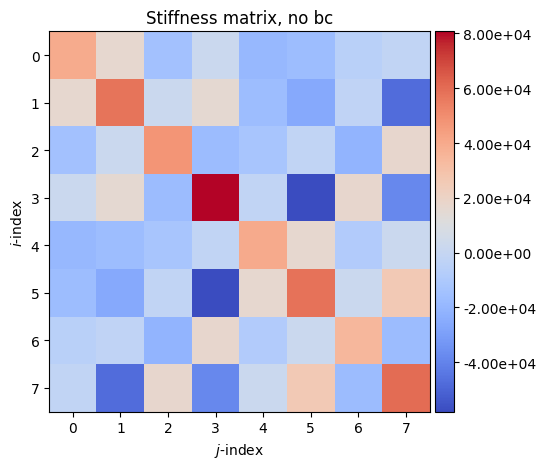

In [83]:
# Plot k heatmap
fig, ax = plt.subplots()
mfe.plot.plot_stiffness_heatmap(fig, ax, k)
ax.set_title(r'Stiffness matrix, no bc')
fig.tight_layout()

In [84]:
# Create bcs
disp = {
    'x_disp': {
        1: 0,
        4: 0,
    },
    'y_disp': {
        1: 0,
    }
}

# Apply bcs
old_max = np.max(k)
k, f = apply_disp_bcs(disp['x_disp'], disp['y_disp'], k, f)

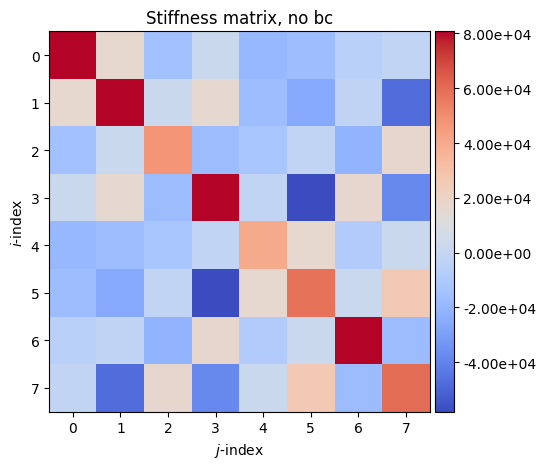

In [85]:
# Plot update stiffness heatmap
fig, ax = plt.subplots()
mfe.plot.plot_stiffness_heatmap(fig, ax, k, vmax=old_max)
ax.set_title(r'Stiffness matrix, no bc')
fig.tight_layout()

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'u$_{1}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
        <Axes: title={'center': 'u$_{2}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>],
       dtype=object))

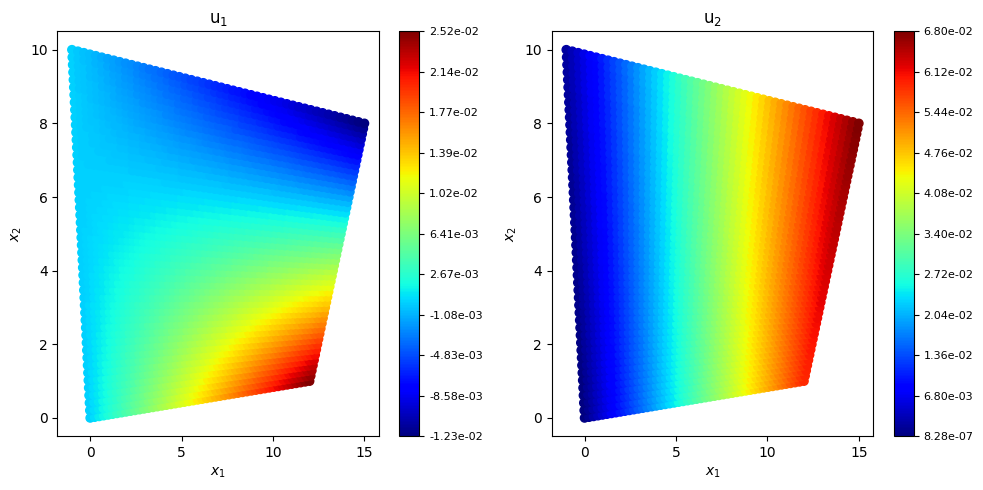

In [86]:
# Solve for nodal displacements
q = np.matmul(np.linalg.inv(k), f)

# Map to element
natural_grid = mfe.utils.make_natural_grid()
x_elem = elem.map_to_element(elem.x_element, natural_grid)
q_elem = elem.map_to_element(q, natural_grid)

# Plot
mfe.plot.plot_element_displacement(q_elem, x_elem, method='scatter')

In [87]:
# Get connectivity matrix and nodal coordinates, then assemble the mesh
G, node_coords = mfe.utils.read_mesh_from_csv(**MESH_FILES)
elems = mfe.solve.assemble_mesh(G, node_coords)

In [88]:

# Set the element material property matrix and thickness
D = mfe.baseclasses.Material(E=70000, nu=0.33).D_isotropic_plane_strain()
thickness = 0.1
for e in elems:
    e.D = D.copy()
    e.thickness = thickness

# Create displacement bc dict
disp = {
    'x_disp': {
        26: 0,
        21: 0,
        13: 0,
        8: 0,
        5: 0,
    },
    'y_disp': {
        16: 0,
        17: 0,
        18: 0,
        19: 0,
        22: 0,
    }
}

# Set the traction boundary conditions corresponding to elements 1 and 2
constants = [
    np.array([0]), 
    np.array([15])
    # [
    #     np.array([0, -50]), np.array([0, 100])
    # ]
]
loads = [[] for _ in elems]
loads[0] = mfe.load.SurfaceTraction.generate(elems[0], '+y', constants, thickness=elems[0].thickness)
loads[1] = mfe.load.SurfaceTraction.generate(elems[1], '+y', constants, thickness=elems[1].thickness)

# Assemble solution matrices
K, F = mfe.solve.assemble_global_solution(G, elems, loads, 2)

26


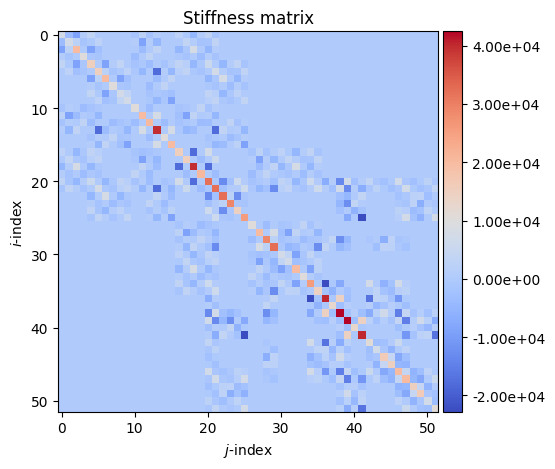

In [89]:
# Plot stiffness
fig, ax = plt.subplots()
mfe.plot.plot_stiffness_heatmap(fig, ax, K)
fig.tight_layout()

In [90]:
# Apply displacement boundary conditions and compute nodal displacements
K, F = apply_disp_bcs(disp['x_disp'], disp['y_disp'], K, F)
Q = np.matmul(np.linalg.inv(K), F)

In [91]:
# def make_multivariate(x, y, constants):
#     # constants: list[np.array]

#     # [np.array([0]), np.array([600, -50])]
#     # f = np.zeros()
#     f = []
#     for _, cgroup in enumerate(constants):
#         if type(cgroup) != list:
#             soln = np.sum(np.array([cgroup[i]*x**i for i in range(len(cgroup))]), axis=0)
#             f.append(soln)
#             continue
#         elif len(cgroup) == 2:
#             soln = np.sum(np.array([cgroup[0][i]*x**i for i in range(len(cgroup[0]))]), axis=0)
#             soln += np.sum(np.array([cgroup[1][i]*y**i for i in range(len(cgroup[1]))]), axis=0)
#             f.append(soln)
#         # f.append(soln)
#     return f

# constants = [
#     np.array([0]), 
#     [
#         np.array([0, -50]), np.array([0, 100])
#     ]
# ]
# f = make_multivariate(3, 6, constants)

# def compute_fs(elem_coords: np.ndarray, constants: list[list[np.ndarray] | np.ndarray]) -> np.ndarray:
#     '''
#     Compute the surface traction forces at the integration points in the local element coordinate system.
#     '''
#     grid_shape = elem_coords.shape[0:2]
#     f_surf = []
#     for _, cgroup in enumerate(constants):
#         if type(cgroup) != list:
#             soln = np.sum(np.array([cgroup[i]*elem_coords[:, :, 0, :]**i for i in range(len(cgroup))]), axis=0)
#         elif len(cgroup) == 2:
#             soln = np.sum(np.array([cgroup[0][i]*elem_coords[:, :, 0, :]**i for i in range(len(cgroup[0]))]), axis=0)
#             soln += np.sum(np.array([cgroup[1][i]*elem_coords[:, :, 1, :]**i for i in range(len(cgroup[1]))]), axis=0)
#         f_surf.append(soln)
#     f_surf = np.array(f_surf).reshape((2, 1, *grid_shape))
#     return mfe.utils.shift_ndarray_for_vectorization(f_surf)

#     # f_surf = np.array([
#     #     f(elem_coords[:, :, i, :], c)
#     #     for i, (f, c) in enumerate(zip(self.funcs, self.constants))
#     # ]).reshape((2, 1, *grid_shape))
#     # return mfe.utils.shift_ndarray_for_vectorization(f_surf)

# # print(elems[0].integration_points.natural_coords)
# # print(loads[0].integration_points.element_coords)
# print(loads[0].constants)
# test_load = mfe.load.SurfaceTraction.generate(elems[0], '+y', constants, thickness=elems[0].thickness)
# test_load.integration_points.element_coords = elem.map_to_element(elem.x_element, test_load.integration_points.natural_coords)

# f_surf = compute_fs(test_load.integration_points.element_coords, test_load.constants)

# f_test = test_load.compute_fs(test_load.integration_points.element_coords)
# f = test_load.compute_force_vector(elems[0])

[ 2.29618509e-03  1.24678257e-03  1.84299112e-03  1.94294692e-03
  1.14384627e-03  2.70383003e-03  5.93529488e-04  3.90714861e-03
 -9.26843151e-05  4.81252593e-03  2.60965087e-04  3.72079607e-03
  7.73848821e-04  3.10518900e-03  1.48647497e-03  2.12463816e-03]
[ 1.14384627e-03  2.70383003e-03  4.01591034e-04  4.00477226e-03
  1.70563366e-09  4.89396769e-03 -4.88684100e-09  5.34734130e-03
 -4.69706717e-09  5.91900005e-03 -1.27242915e-04  5.46681245e-03
 -9.26843151e-05  4.81252593e-03  5.93529488e-04  3.90714861e-03]
[3.26551363e-03 3.08724275e-09 3.00698639e-03 2.29982970e-08
 2.66066540e-03 1.27385994e-08 2.02758303e-03 1.34834220e-03
 1.14384627e-03 2.70383003e-03 1.84299112e-03 1.94294692e-03
 2.29618509e-03 1.24678257e-03 2.99818298e-03 5.46032399e-04]
[2.66066540e-03 1.27385994e-08 2.50302051e-03 1.70011390e-08
 2.07914554e-03 7.76077857e-09 1.86668883e-03 1.71935290e-03
 1.35090641e-03 3.15555583e-03 1.13890868e-03 2.71997379e-03
 1.14384627e-03 2.70383003e-03 2.02758303e-03 1.34

<Axes: xlabel='$x_{1}$', ylabel='$x_{2}$'>

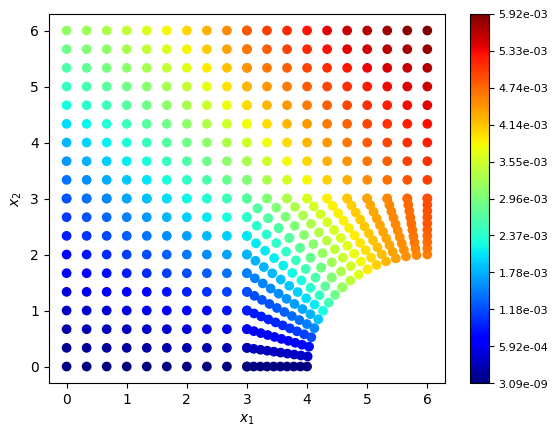

In [127]:
# Plot assembly.
x_ = []
q_ = []
natural_grid = mfe.utils.make_natural_grid(10)
for i in range(G.shape[0]):
    x_grid = elems[i].map_to_element(elems[i].x_element, natural_grid)
    q_grid_ = []
    for j in range(G[i].shape[0]):
        for component in range(2):
            component += 1
            idx_row = mfe.solve._get_node_matrix_index(G[i][j], component, 2)
            q_grid_.append(Q[idx_row, 0])
    print(np.array(q_grid_))
    q_grid = elems[i].map_to_element(np.array(q_grid_), natural_grid)

    x_.append(x_grid)
    q_.append(q_grid)

    # idx_col = [i-1 for i in G[i].tolist()]
    # Q = 
    # q_grid = elems[i].map_to_element(Q[idx_slice])
    # q_grid = elems[i].map_to_element(elems[i].x_element, natural_grid)
    # q_
# print(Q[idx_slice])
x_ = np.vstack(x_)
q_ = np.vstack(q_)
# print(len(q))
mfe.plot.plot_interpolated_element(x_, q_[:, :, 1, 0], method='scatter')
# print(np.vstack(x_).shape)
